In [3]:

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from typing import Sequence
import flax.linen as nn
import optax
jax.config.update("jax_numpy_rank_promotion", "raise")

### Data, two Gaussians, Z =3

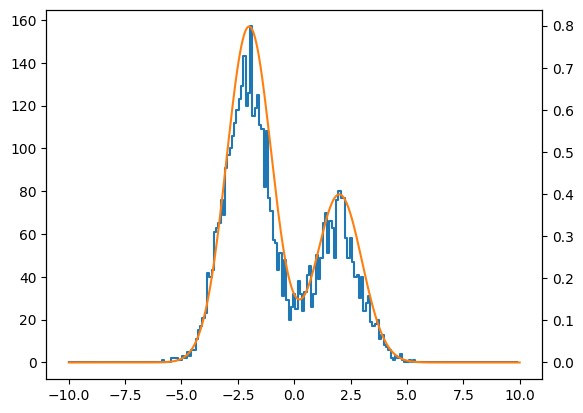

In [4]:
p = lambda x: 2*jax.scipy.stats.norm.pdf(x, loc=-2, scale=1)+jax.scipy.stats.norm.pdf(x, loc=2, scale=1)
E0 = lambda x: -jnp.log(p(x))
## sum of two gaussian densities with weights (2,1) -> Z =3

key = jax.random.PRNGKey(1)
N = 5000
X = jax.random.normal(key,(N,1))
offset = (((jax.random.randint(key,(N,1),0,3)-.5)>1)*2-1) * 2
X = X+offset
fig, ax = plt.subplots()
bins = jnp.linspace(-10,10,200)
ax.step(bins[:-1],jnp.histogram(X,bins)[0])
x = jnp.linspace(-10,10,1000)
ax2=ax.twinx()
ax2.plot(x,p(x),c='C1')

In [5]:
class E_fn(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x, t):
        x = jnp.concatenate((x,t))     
        for i, feat in enumerate(self.features):
            x = nn.Dense(feat)(x)
            if i != len(self.features) - 1:
                x = nn.swish(x)
        return x.sum()

In [6]:
class DPM():
    def __init__(self):
        sigma_min, sigma_max = 0.001,0.999
        self.lambda_a,self.lambda_b = jnp.arccos(sigma_max), jnp.arccos(sigma_min)
        self.E_fn = E_fn([64,64,64])
        key = jax.random.PRNGKey(1)
        self.params = self.E_fn.init(key,t=jnp.ones(1,),x=jnp.ones(1,))
        
    
    def beta(self,t):
        return 2 * (self.lambda_b - self.lambda_a) * jnp.tan(self.lambda_a + t * (self.lambda_b-self.lambda_a))
    
    def gamma(self,t): # exp(.5 * int 0 to t beta(s) ds)
        return jnp.cos(self.lambda_a + t * (self.lambda_b-self.lambda_a))

    def sigma(self,t): #sigma^2 = 1- exp(int 0 to t beta(s) ds)
        return jnp.sin(self.lambda_a + t * (self.lambda_b-self.lambda_a))


    def E(self,params,x,t):
        E1 = lambda x:-jax.scipy.stats.norm.logpdf(x, loc=0, scale=1)
        return t[0]*(1-t[0])*self.E_fn.apply(params,x,t) + (1-t[0]) * E0(x).sum() + t[0] * E1(x).sum()



    def train(self,X,key,steps,lr,batch_size=32):
        optim = optax.adam(learning_rate=lr)
        opt_state = optim.init(self.params)

        def loss_fn(params,key,x0):
            key1,key2 = jax.random.split(key)
            t = jax.random.uniform(key1,(len(x0),1))
            z = jax.random.normal(key2,x0.shape)
            xt = self.gamma(t)*x0 + z*self.sigma(t)
            
            dEdx,dEdt = jax.vmap(jax.grad(self.E,(1,2)),in_axes=(None,0,0))(params,xt,t)

            score_pred = -dEdx*self.sigma(t)
            score_target = -z

            L = ((score_pred -score_target)**2).sum(-1,keepdims=True)
            return L.mean()

        @jax.jit
        def update_step(key,params,opt_state,x_batch):
            grad = jax.grad(lambda p: loss_fn(params = p, key = key,x0 = x_batch))(params)
            updates, opt_state = optim.update(grad, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params,opt_state



        for i in range(steps):
            
            key1,key2,key = jax.random.split(key,3)
            x_batch =jax.random.choice(key1,X,(batch_size,))
            self.params,opt_state =update_step(key2,self.params,opt_state,x_batch)
            print(f'step {i+1}/{steps}',end='\r')



    def sample(self,key,N,num_steps):
        dt = 1/num_steps
        @jax.jit
        def step(key,t,x,logZ):
            key = jax.random.split(key,2)[0]
            z = jax.random.normal(key,x.shape)
            dEdx,dEdt =  jax.vmap(jax.grad(self.E,(1,2)),in_axes=(None,0,None))(self.params,x,t.reshape(1,))
            score = -dEdx
            logZ += dt*dEdt.reshape(-1)
            x += .5*self.beta(t) * (x +2*score)* dt + jnp.sqrt(self.beta(t))*z *(dt)**(1/2)
            return key,t-dt,x,logZ

        x = jax.random.normal(jax.random.PRNGKey(4),(N,1))
        logZ = jnp.zeros(N)
        t = 1-dt/2.
        
        
        for _ in range(num_steps):
            key,t,x,logZ = step(key,t,x,logZ)
        return x,logZ


### Train

In [7]:
model = DPM()
model.train(X,key,steps=15000,lr=1e-3)


### Sample, estimate logZ

3.0421011


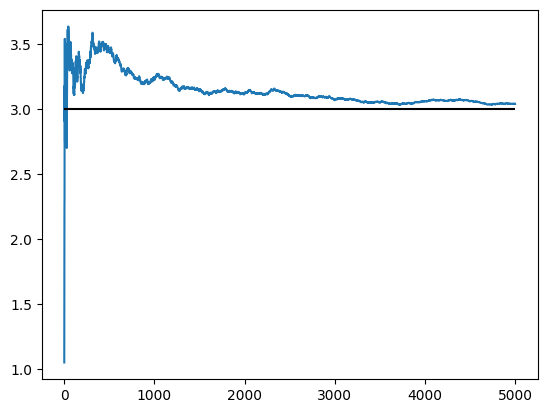

In [8]:

samples,logZ = model.sample(key,N=len(X),num_steps=1500)

plt.plot(jnp.exp(logZ.cumsum()/jnp.arange(1,len(logZ)+1)))
plt.hlines([3],0,len(logZ),colors=['black'])
print(jnp.exp(logZ.mean())) # should be close to 3


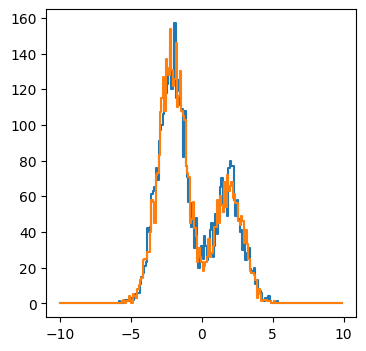

In [9]:
plt.figure(figsize=(4,4))
plt.step(bins[:-1],jnp.histogram(X,bins)[0])
plt.step(bins[:-1],jnp.histogram(samples,bins)[0])

### Learnt Energy interpolation

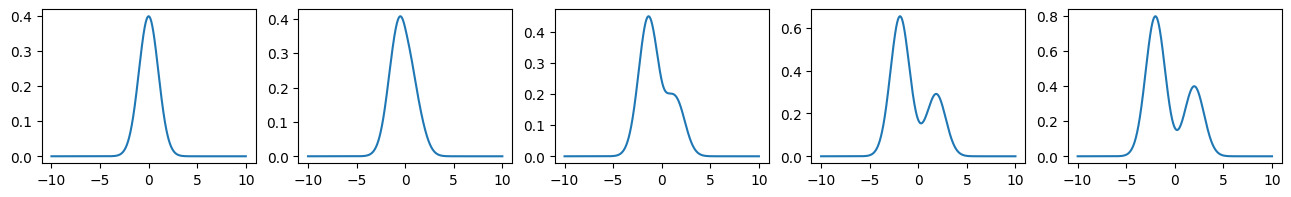

In [10]:
x = jnp.linspace(-10,10,1000).reshape(-1,1)

plt.figure(figsize=(16,2))
n_steps = 5
for i,t in enumerate(jnp.linspace(1,0,n_steps)):
    plt.subplot(100+10*n_steps+i+1)
    plt.plot(x,jnp.exp(-jax.vmap(model.E,in_axes=(None,0,None))(model.params,x,jnp.array([t]))))
    #plt.yticks([])